In [ ]:
# SPDX-FileCopyrightText: Copyright (c) 2022 NVIDIA CORPORATION & AFFILIATES. All rights reserved.

# SPDX-License-Identifier: Apache-2.0

#

# Licensed under the Apache License, Version 2.0 (the "License");

# you may not use this file except in compliance with the License.

# You may obtain a copy of the License at

#

# http://www.apache.org/licenses/LICENSE-2.0

#

# Unless required by applicable law or agreed to in writing, software

# distributed under the License is distributed on an "AS IS" BASIS,

# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.

# See the License for the specific language governing permissions and

# limitations under the License.

In [2]:
import os
import sys
import re
import pickle as pk

import graph_tool as gt

import numpy as np
import pandas as pd

import dgl
import torch

/raid/yba/miniconda3/envs/andlai_dgl/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Inspection of all graphs

In [13]:
print(os.listdir('../data/8_rat/'))

gs = []
for file in os.listdir('../data/8_rat/'):
    gs.append(dgl.load_graphs(f'../data/8_rat/{file}')[0][0])

['usb.graph.bin', 'des.graph.bin', 'BM64.graph.bin', 'usb_cdc_core.graph.bin', 'aes192.graph.bin', 'wbqspiflash.graph.bin', 'jpeg_encoder.graph.bin', 'usbf_device.graph.bin', 'blabla.graph.bin', 'y_huff.graph.bin', 'zipdiv.graph.bin', 'spm.graph.bin', 'salsa20.graph.bin', 'cic_decimator.graph.bin', 'synth_ram.graph.bin', 'aes_cipher.graph.bin', 'picorv32a.graph.bin', 'aes128.graph.bin', 'aes256.graph.bin', 'genericfir.graph.bin', 'xtea.graph.bin']


In [14]:
for target in ['n_rats', 'n_net_delays', 'n_ats', 'n_slews']:
    print(f'----- target = {target} -----')
    for g in gs:
        print(g.ndata[target].mean(axis=0).numpy(), g.ndata[target].std(axis=0).numpy())

----- target = n_rats -----
[-inf -inf  inf  inf] [nan nan nan nan]
[-inf -inf  inf  inf] [nan nan nan nan]
[-inf -inf  inf  inf] [nan nan nan nan]
[-inf -inf  inf  inf] [nan nan nan nan]
[-inf -inf  inf  inf] [nan nan nan nan]
[-inf -inf  inf  inf] [nan nan nan nan]
[-inf -inf  inf  inf] [nan nan nan nan]
[-inf -inf  inf  inf] [nan nan nan nan]
[-inf -inf  inf  inf] [nan nan nan nan]
[-inf -inf  inf  inf] [nan nan nan nan]
[-inf -inf  inf  inf] [nan nan nan nan]
[-inf -inf  inf  inf] [nan nan nan nan]
[-inf -inf  inf  inf] [nan nan nan nan]
[-inf -inf  inf  inf] [nan nan nan nan]
[-inf -inf  inf  inf] [nan nan nan nan]
[-inf -inf  inf  inf] [nan nan nan nan]
[-inf -inf  inf  inf] [nan nan nan nan]
[-inf -inf  inf  inf] [nan nan nan nan]
[-inf -inf  inf  inf] [nan nan nan nan]
[-inf -inf  inf  inf] [nan nan nan nan]
[-inf -inf  inf  inf] [nan nan nan nan]
----- target = n_net_delays -----
[0.00345587 0.00338516 0.00357947 0.00343731] [0.01738612 0.01733653 0.01798983 0.01746103]
[0.039

### Inspection of spm DGL graph

In [2]:
g = dgl.load_graphs('../data/8_rat/spm.graph.bin')[0][0]
g

Graph(num_nodes={'node': 1121},
      num_edges={('node', 'cell_out', 'node'): 700, ('node', 'net_in', 'node'): 765, ('node', 'net_out', 'node'): 765},
      metagraph=[('node', 'node', 'cell_out'), ('node', 'node', 'net_in'), ('node', 'node', 'net_out')])

In [3]:
print('[node data] ( = dstdata)')
for nkey, ndat in g.ndata.items():
    assert type(ndat) == torch.Tensor, 'Type must be torch.Tensor'
    print(f'{nkey:22s} {ndat.shape}')
    if nkey == 'nf':
        nf = ndat
        for fkey, frange in [('is_prim IO', [0,1]), ('fanout(1) or in(0)', [1,2]), ('dis to tlrb', [2,6]), ('EL/RF cap', [6,10])]:
            print(f'  {fkey:20s} {ndat[:, frange[0]:frange[1]].shape}')
print()

print('[edge data]')
for ekey, edat in g.edata.items():
    assert type(edat) == dict, 'Type must be dict'
    print(f'{ekey}:')
    for edat_key, edat_dat in edat.items():
        print(f'  {f"{edat_key}":30s} {edat_dat.shape}')

nf[:, 0], nf[:, 1], nf[:, 2:6], nf[:, 6:]

[node data] ( = dstdata)
n_rats                 torch.Size([1121, 4])
n_net_delays           torch.Size([1121, 4])
n_ats                  torch.Size([1121, 4])
n_slews                torch.Size([1121, 4])
nf                     torch.Size([1121, 10])
  is_prim IO           torch.Size([1121, 1])
  fanout(1) or in(0)   torch.Size([1121, 1])
  dis to tlrb          torch.Size([1121, 4])
  EL/RF cap            torch.Size([1121, 4])
n_is_timing_endpt      torch.Size([1121])

[edge data]
e_cell_delays:
  ('node', 'cell_out', 'node')   torch.Size([700, 4])
ef:
  ('node', 'cell_out', 'node')   torch.Size([700, 512])
  ('node', 'net_in', 'node')     torch.Size([765, 2])
  ('node', 'net_out', 'node')    torch.Size([765, 2])


(tensor([0., 0., 0.,  ..., 0., 1., 0.]),
 tensor([0., 1., 0.,  ..., 0., 1., 0.]),
 tensor([[103.4891,  73.5109,  63.1130, 114.8870],
         [103.5326,  73.4674,  68.6522, 109.3478],
         [ 32.5109, 144.4891, 110.4174,  67.5826],
         ...,
         [ 19.4130, 157.5870, 175.5000,   2.5000],
         [-12.0022, 189.0022, -23.0022, 201.0022],
         [168.6848,   8.3152,  38.3804, 139.6196]]),
 tensor([[0.0021, 0.0021, 0.0019, 0.0018],
         [0.0000, 0.0000, 0.0000, 0.0000],
         [0.0021, 0.0021, 0.0019, 0.0018],
         ...,
         [0.0023, 0.0021, 0.0021, 0.0020],
         [0.0000, 0.0000, 0.0000, 0.0000],
         [0.0023, 0.0021, 0.0023, 0.0021]]))

In [5]:
tmp_df = pd.DataFrame(g.edata['ef'][('node', 'net_in', 'node')].numpy())
tmp_df = np.round(tmp_df, 6)
tmp_df.to_csv('tmp_df.csv')
# for row in g.edata['ef'][('node', 'cell_out', 'node')][:, :120].numpy():
#     print(row)
tmp_df

,0,1
0,0.043480,5.539124
1,11.956520,5.539154
2,2.021736,6.286957
3,2.021736,12.199989
4,1.043488,6.286957
...,...,...
760,-127.415207,-198.502167
761,-141.415207,-80.241302
762,-21.415218,-115.719566
763,-31.415216,-198.502167


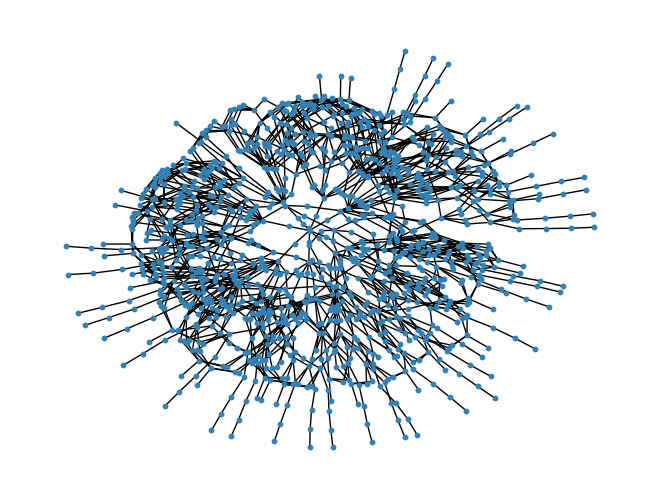

In [39]:
import networkx as nx
# Since the actual graph is undirected, we convert it for visualization
# purpose.
nx_G = g.to_networkx().to_undirected()
# Kamada-Kawaii layout usually looks pretty for arbitrary graphs
pos = nx.kamada_kawai_layout(nx_G)
nx.draw(nx_G, pos, with_labels=False, node_color=[[.2, .5, .7]], node_size=10, width=1)

### Parse .lib file

In [101]:
# parse the library
from liberty.parser import parse_liberty

relative_lib_dir = '../netlists/techlib'
liberty_file = 'sky130_fd_sc_hd__ff_n40C_1v95.lib'

# Read and parse a library.
if 'library' not in globals():
    library = parse_liberty(open(f'{relative_lib_dir}/{liberty_file}').read())

# Format the library.
# print(str(library))

# Loop through all cells.
pin_groups = 0
for cell_group in library.get_groups('cell'):
    name = cell_group.args[0]
    # print(name)

    pin_groups += len(cell_group.get_groups('pin'))
    # # Loop through all pins of the cell.
    # for pin_group in cell_group.get_groups('pin'):
    #     pin_name = pin_gropu.args[0]
    #     print(pin_name)

    #     # Access a pin attribute.
    #     some_attribute = pin_group['some_attribute']

In [105]:
cell_group.attributes

cell_group.get_groups('pin')[0]

pin (["A"]) t{[input_voltage : "GENERAL", capacitance : 0.002447, clock : "false", direction : "input", fall_capacitance : 0.002301, max_transition : 1.5, related_ground_pin : "VGND", related_power_pin : "VPWR", rise_capacitance : 0.002592], [ccsn_first_stage ([]) t{[is_inverting : "true", is_needed : "true", miller_cap_fall : 0.000787934, miller_cap_rise : 0.000649529, stage_type : "both"], [dc_current (["ccsn_dc"]) t{[index_1 : ["-1.9500000000, -0.9750000000, -0.3900000000, -0.1950000000, 0.0000000000, 0.0975000000, 0.1950000000, 0.2925000000, 0.3900000000, 0.4875000000, 0.5850000000, 0.6825000000, 0.7800000000, 0.8775000000, 0.9750000000, 1.0725000000, 1.1700000000, 1.2675000000, 1.3650000000, 1.4625000000, 1.5600000000, 1.6575000000, 1.7550000000, 1.8525000000, 1.9500000000, 2.1450000000, 2.3400000000, 2.9250000000, 3.9000000000"], index_2 : ["-1.9500000000, -0.9750000000, -0.3900000000, -0.1950000000, 0.0000000000, 0.0975000000, 0.1950000000, 0.2925000000, 0.3900000000, 0.48750000

In [64]:
pin = cell_group.get_groups('pin')[0]
print(pin.attributes)

ccsn_first_stage = pin.get_groups('ccsn_first_stage')[0]
print(ccsn_first_stage.attributes)

dc_current = ccsn_first_stage.get_groups('dc_current')[0]
print(dc_current.attributes)

dc_current_values = dc_current.get_attribute('values')
print(dc_current_values[0])

[input_voltage : "GENERAL", capacitance : 0.002447, clock : "false", direction : "input", fall_capacitance : 0.002301, max_transition : 1.5, related_ground_pin : "VGND", related_power_pin : "VPWR", rise_capacitance : 0.002592]
[is_inverting : "true", is_needed : "true", miller_cap_fall : 0.000787934, miller_cap_rise : 0.000649529, stage_type : "both"]
[index_1 : ["-1.9500000000, -0.9750000000, -0.3900000000, -0.1950000000, 0.0000000000, 0.0975000000, 0.1950000000, 0.2925000000, 0.3900000000, 0.4875000000, 0.5850000000, 0.6825000000, 0.7800000000, 0.8775000000, 0.9750000000, 1.0725000000, 1.1700000000, 1.2675000000, 1.3650000000, 1.4625000000, 1.5600000000, 1.6575000000, 1.7550000000, 1.8525000000, 1.9500000000, 2.1450000000, 2.3400000000, 2.9250000000, 3.9000000000"], index_2 : ["-1.9500000000, -0.9750000000, -0.3900000000, -0.1950000000, 0.0000000000, 0.0975000000, 0.1950000000, 0.2925000000, 0.3900000000, 0.4875000000, 0.5850000000, 0.6825000000, 0.7800000000, 0.8775000000, 0.9750000

In [74]:
from pyverilog.vparser.parser import parse
from pyverilog.vparser.ast import Decl, InstanceList, Input, Wire, Output, Instance, PortArg, Identifier, Pointer

relative_v_dir = '../netlists/spm'
v_file = 'spm.synthesis_preroute.v'

filelist = [f'{relative_v_dir}/{v_file}']

ast, directives = parse(filelist,
                        preprocess_include=[],
                        preprocess_define=[])
astm = ast.children()[0].children()[0]
astm, astm.name

Generating LALR tables


(<pyverilog.vparser.ast.ModuleDef at 0x7f5372146390>, 'spm')

In [79]:
Pointer.children

()

In [97]:
# # construct a graph_tool graph
# g = gt.Graph()

# define wires, pins, cells
nets, cells = {}, {}

# create list of ports
portlist = []
for port in astm.portlist.children():
    portlist.append(port.name)

pin_count = 0
in_port_count = 0
net_name_count = 0

# go into hierarchy and parse netlist
for elem in astm.items:
    if type(elem) == Decl:
        assert len(elem.children()) == 1
        attr = elem.children()[0]
        if type(attr) == Wire:
            # Extract Wire Name
            nets[attr.name] = len(nets) + 1
        elif type(attr) != Input and type(attr) != Output:
            assert False, 'assert type(attr) in [Wire, Input, Output]' + f'{type(attr)}'
    elif type(elem) == InstanceList:
        assert len(elem.children()) == 1
        cell = elem.children()[0]
        assert type(cell) == Instance, 'assert type(attr) == Instance ... ' + f'{type(cell)}'
        # skip FILLER, PHY, and TAP cells
        if cell.name[:7] == 'FILLER_' or cell.name[:4] == 'PHY_' or cell.name[:4] == 'TAP_':
            continue
        cells[cell.name] = {'module': cell.module}
        # assign the pins to this cell
        pins = {}
        for arg in cell.children():

            pin_count += 1

            assert type(arg) == PortArg, 'assert type(arg) == PortArg ... ' + f'{type(arg)}'
            # arg.portname
            for ptr_idf in arg.children():
                if type(ptr_idf) == Identifier:
                    # print(ptr_idf.name)

                    if ptr_idf.name in portlist:
                        in_port_count += 1
                    elif ptr_idf.name in nets.keys():
                        net_name_count += 1
                elif type(ptr_idf) == Pointer:
                    assert len(ptr_idf.children()) == 2
                    idf, idc = ptr_idf.children()

                    if idf.name in portlist:
                        in_port_count += 1
                    elif idf.name in nets.keys():
                        net_name_count += 1
                else:
                    assert False, 'assert type(ptr_idf) in [Identifier, Pointer]' + f'{type(ptr_idf)}'
    else:
        assert False, 'assert type(item) in [Decl, InstanceList]'

In [83]:
idf.name

'x'

In [98]:
pin_count, in_port_count, net_name_count

(2369, 1320, 1049)

In [95]:
1121 - (2369 - 1320)

72

In [100]:
ast.show()

Source:  (at 1)
  Description:  (at 1)
    ModuleDef: spm (from 1 to 5342)
      Paramlist:  (at 0)
      Portlist:  (at 1)
        Port: VGND, None (at 1)
        Port: VPWR, None (at 1)
        Port: clk, None (at 1)
        Port: p, None (at 1)
        Port: rst, None (at 1)
        Port: y, None (at 1)
        Port: x, None (at 1)
      Decl:  (at 8)
        Input: VGND, False (at 8)
      Decl:  (at 9)
        Input: VPWR, False (at 9)
      Decl:  (at 10)
        Input: clk, False (at 10)
      Decl:  (at 11)
        Output: p, False (at 11)
      Decl:  (at 12)
        Input: rst, False (at 12)
      Decl:  (at 13)
        Input: y, False (at 13)
      Decl:  (at 14)
        Input: x, False (at 14)
          Width:  (at 14)
            IntConst: 31 (at 14)
            IntConst: 0 (at 14)
      Decl:  (at 16)
        Wire: _000_, False (at 16)
      Decl:  (at 17)
        Wire: _001_, False (at 17)
      Decl:  (at 18)
        Wire: _002_, False (at 18)
      Decl:  (at 19)
     

### Check the levels of all graphs


In [ ]:
g = dgl.load_graphs('../data/8_rat/spm.graph.bin')[0][0]
g

In [5]:
available_data = 'blabla usb_cdc_core BM64 jpeg_encoder salsa20 usbf_device aes128 wbqspiflash aes192 cic_decimator xtea aes256 des spm y_huff aes_cipher picorv32a synth_ram zipdiv genericfir usb'.split()

for k in available_data:
    print(k)
    g = dgl.load_graphs('../data/8_rat/{}.graph.bin'.format(k))[0][0]

def gen_topo(g_hetero):
    torch.cuda.synchronize()
    na, nb = g_hetero.edges(etype='net_out', form='uv')
    ca, cb = g_hetero.edges(etype='cell_out', form='uv')
    g = dgl.graph((torch.cat([na, ca]).cpu(), torch.cat([nb, cb]).cpu()))
    topo = dgl.topological_nodes_generator(g)
    return topo

blabla
usb_cdc_core
BM64
jpeg_encoder
salsa20
usbf_device
aes128
wbqspiflash
aes192
cic_decimator
xtea
aes256
